<a href="https://colab.research.google.com/github/jianning1/Capstone-Project/blob/master/Bi_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Python Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer


from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.1.0

Uninstalling tensorflow-2.2.0rc2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc2
     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 36.7MB/s 
     |████████████████████████████████| 450kB 41.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=19cf6ad9281d65fcb69ea92b9b535f35ded781a8504ffda02886996b48e5c7d0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
  

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


# Import and slice data

In [4]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
#import io
mydata = pd.read_csv('/gdrive/My Drive/Full-Economic-News-DFE.csv', encoding = "ISO-8859-1")

In [6]:
data = mydata[['_unit_id','positivity', 'relevance', 'date','headline', 'text']]

data.head()

,_unit_id,positivity,relevance,date,headline,text
0,842613455,3.0,yes,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,842613456,NaN,no,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,842613457,NaN,no,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,842613458,NaN,no,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,842613459,3.0,yes,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


# Data Description

In [10]:
dist = data[['_unit_id','relevance']].groupby('relevance').count()
dist

,_unit_id
relevance,
no,6571
not sure,9
yes,1420


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


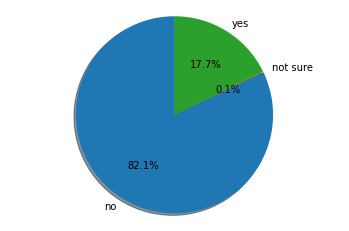

In [11]:
fig1, ax1 = plt.subplots()
sizes = dist.values
label = dist.index.tolist()

ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [12]:
dist = data[data['positivity']!=0][['positivity','_unit_id']].groupby('positivity').count()
dist

,_unit_id
positivity,
2.0,35
3.0,343
4.0,255
5.0,205
6.0,214
7.0,295
8.0,71
9.0,2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


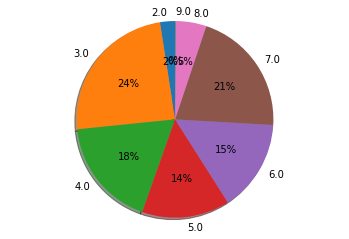

In [10]:
fig1, ax1 = plt.subplots()
sizes = dist.values
label = dist.index.tolist()

ax1.pie(sizes, labels=label, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

# Pre-processing

In [7]:
data['positivity'].fillna(0, inplace = True)
data.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,_unit_id,positivity,relevance,date,headline,text
0,842613455,3.0,yes,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,842613456,0.0,no,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,842613457,0.0,no,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,842613458,0.0,no,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,842613459,3.0,yes,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


## Remove ambiguious data

In [0]:
data = data[data.relevance != 'not sure']
data.relevance = data.relevance.map(dict(yes=1, no=0))
data['texts'] = data['headline'] + (' ') + data['text']

## Check Embeddings Coverage 
Self-defined funtion to check the proportion of words and texts covered by selected pre-trained word vectors

In [0]:
import operator
def build_vocab(X):
    
    news = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for n in news:
        for word in n:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

### Pretrained Word Embedding loading

In [10]:
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


In [11]:
texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

GloVe Embeddings cover 23.86% of vocabulary and 75.26% of text in texts


## Remove url and html in text 

In [0]:
def rm_url(contents):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',contents)

def rm_html(contents):
    html=re.compile(r'<.*?>')
    return html.sub(r'',contents)

In [0]:
data['texts'] = data['texts'].apply(rm_url)
data['texts'] = data['texts'].apply(rm_html)

In [14]:
data.head(5)

,_unit_id,positivity,relevance,date,headline,text,texts
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,Yields on CDs Fell in the Latest Week NEW YORK...
1,842613456,0.0,0,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...,The Morning Brief: White House Seeks to Limit ...
2,842613457,0.0,0,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...,Banking Bill Negotiators Set Compromise --- Pl...
3,842613458,0.0,0,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...,Manager's Journal: Sniffing Out Drug Abusers I...
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,Currency Trading: Dollar Remains in Tight Rang...


## Remove non-alphabet characters and lower case

In [0]:
data['texts'] = [re.sub("[^A-Za-z ']+", ' ', str(line)).lower() for line in data['texts']]

In [16]:
data.head(5)

,_unit_id,positivity,relevance,date,headline,text,texts
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,yields on cds fell in the latest week new york...
1,842613456,0.0,0,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...,the morning brief white house seeks to limit ...
2,842613457,0.0,0,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...,banking bill negotiators set compromise plan...
3,842613458,0.0,0,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...,manager's journal sniffing out drug abusers i...
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,currency trading dollar remains in tight rang...


In [17]:
texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

GloVe Embeddings cover 83.24% of vocabulary and 98.70% of text in texts


In [18]:
data.head(5)

,_unit_id,positivity,relevance,date,headline,text,texts
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,yields on cds fell in the latest week new york...
1,842613456,0.0,0,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...,the morning brief white house seeks to limit ...
2,842613457,0.0,0,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...,banking bill negotiators set compromise plan...
3,842613458,0.0,0,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...,manager's journal sniffing out drug abusers i...
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,currency trading dollar remains in tight rang...


## Lemmatization and Stopwords removal

In [19]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]  #
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

t = time()

data['texts'] = [cleaning(doc) for doc in nlp.pipe(data['texts'], batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.16 mins


In [20]:
texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

GloVe Embeddings cover 86.54% of vocabulary and 99.48% of text in texts


In [21]:
data.head(5)

,_unit_id,positivity,relevance,date,headline,text,texts
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,yield cd fall late week new york yield cert...
1,842613456,0.0,0,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...,morning brief white house seek limit child i...
2,842613457,0.0,0,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...,banking bill negotiator set compromise plan...
3,842613458,0.0,0,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...,manager journal sniff drug abuser quick fix ...
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,currency trading dollar remain tight range a...


## Stemming

In [0]:
#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()

In [0]:
#from nltk.stem import SnowballStemmer
#stemmer = SnowballStemmer(language='english')

In [0]:
#data['texts1'] = [[stemmer.stem(x) for x in line.split()] for line in data['texts']]


In [0]:
#d = data['texts1']
#for i in range(len(d)):
#  d[d.index[i]]= ' '.join(d[d.index[i]])
#data['texts1'] = d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts1'], glove_embeddings)
#print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

GloVe Embeddings cover 70.40% of vocabulary and 97.55% of text in texts


Either run before or after lemmatization, vocabulary coverage dropped to 70%, therefore, do not include stemming

# Exploratory Data Analysis

##Length and word counts of texts

In [26]:
# length of headline and text for all news
texts_len_r = data['texts'].str.len()
# number of words in headline for irrelevant news
texts_word_counts_r = data['texts'].str.split().str.len()

print('Total texts has {} to {} characters, {} to {} words.'.format(texts_len_r.min(),
                                                                    texts_len_r.max(),
                                                                    texts_word_counts_r.min(),
                                                                    texts_word_counts_r.max()))

Total texts has 83 to 3379 characters, 10 to 432 words.


Text(0.5, 1.0, 'number of words in headline and text')

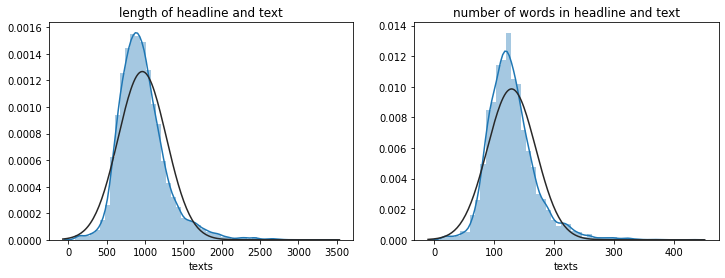

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(texts_len_r, ax = axes[0], fit=stats.norm, norm_hist=True)
axes[0].set_title('length of headline and text')

sns.distplot(texts_word_counts_r, ax = axes[1], fit=stats.norm, norm_hist=True)
axes[1].set_title('number of words in headline and text')

## Ngrams

In [0]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
texts_unigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text):
        texts_unigrams[word] += 1
        
texts_unigrams = pd.DataFrame(sorted(texts_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
texts_bigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text, n_gram=2):
        texts_bigrams[word] += 1
        
texts_bigrams = pd.DataFrame(sorted(texts_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
texts_trigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text, n_gram=3):
        texts_trigrams[word] += 1
        
texts_trigrams = pd.DataFrame(sorted(texts_trigrams.items(), key=lambda x: x[1])[::-1])

In [0]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 60), dpi=50)
plt.tight_layout()

sns.barplot(y=texts_unigrams[0].values[:N], x=texts_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=texts_bigrams[0].values[:N], x=texts_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=texts_trigrams[0].values[:N], x=texts_trigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

# Text Classification

## Oversampling
Oversampling the minority by looking for the synonyms of each word in minor class

In [0]:
#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
df = data[['texts','relevance']][data['relevance']==1]

In [0]:
def oversample(wordlist): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)
        synonym = random.choice(list(synonyms))
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]])
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','relevance'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['relevance']  = df['relevance']
  return augmented_sentences

In [0]:
sentence = df['texts']
word_list = sentence.str.split()
data_cleaned = data[['texts','relevance']]

random.seed(45)
data_cleaned = data_cleaned.append(oversample(word_list))

random.seed(98)
data_cleaned = data_cleaned.append(oversample(word_list))

In [1]:
data_cleaned

NameError: ignored

In [0]:
data_cleaned.reset_index()

,index,texts,relevance
0,0,yield cd fall late week new york yield cert...,1
1,1,morning brief white house seek limit child i...,0
2,2,banking bill negotiator set compromise plan...,0
3,3,manager journal sniff drug abuser quick fix ...,0
4,4,currency trading dollar remain tight range a...,1
...,...,...,...
10826,7973,hydrogen type uranium sulfur tocopherol guan...,1
10827,7974,gasconstant fluorine ace thyroxine tocophe...,1
10828,7984,wye mebibyte lambert type mebibyte type norm...,1
10829,7987,vitamin ampere atomicnumber gravitationalconst...,1


In [0]:
data_cleaned.groupby('relevance').count()

,texts
relevance,
0,6571
1,4260


In [0]:
from sklearn.utils import shuffle

data_cleaned = shuffle(data_cleaned)

In [0]:
data_cleaned

,texts,relevance
3775,land deal help builder stay alive indio smal...,0
1789,home price high decline historical trend ...,1
7190,strong economy get americans go feel wealthi...,0
2248,thyroxin roentgen ane fluorine thyroxin ane n...,1
1326,property report web start firm want real e...,0
...,...,...
3036,business finance gte announce billion preta...,1
6941,dollar interest concern send stock new york ...,0
457,medium vision stock plummet firm see st peri...,0
6088,economy mend thai visit u s washington pol...,0


## Baselines - SVM

In [0]:
from sklearn import metrics

texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])
kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state = 7)


cvscores_svm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall'])

for train, test in kfold.split(texts, labels):
# Train both models on the moviereviews.tsv training set:
  text_clf_lsvc.fit(texts[train], labels[train])
  predictions_svm = text_clf_lsvc.predict(texts[test])
  cm_svm = metrics.confusion_matrix(labels[test], predictions_svm)
  cvscores_svm = cvscores_svm.append({'tp': cm_svm[1][1], 'fp': cm_svm[0][1], 'tn': cm_svm[0][0], 'fn': cm_svm[1][0], 
                                    'accuracy': (cm_svm[1][1]+cm_svm[0][0])/(cm_svm[0][0]+cm_svm[0][1]+(cm_svm[1][0]+cm_svm[1][1])),
                                    'precision': (cm_svm[1][1])/((cm_svm[0][1]+cm_svm[1][1])), 
                                    'recall': (cm_svm[1][1])/((cm_nb[1][1]+cm_svm[1][0])), 
                                    }, 
                                   ignore_index= True)

In [0]:
cvscores_svm.mean()

tp           347.444444
fp            48.777778
tn           681.333333
fn           125.888889
accuracy       0.854861
precision      0.877429
recall         0.787105
dtype: float64

## Bi-LSTM

In [0]:
# some configuration

MAX_SEQUENCE_LENGTH = 427   # max sentence length 427 words
EMBEDDING_DIM = 300    # word vector dimension


### Word Embedding Weights

In [0]:
# T: number of obersavatons in dataset

# load in pre-trained word vectors
# size: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data_cleaned['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# get word -> integer mapping
# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

In [0]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
8506, or 19.81% of total 42944 unique words are not covered


### Padding

In [0]:
sequences = tokenizer.texts_to_sequences(data_cleaned['texts'].values)
texts = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', texts.shape)

Shape of test data tensor: (10831, 427)


### Model

#### Learning rate 0.001

##### Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/100
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3633 - tp: 2190.0000 - fp: 70.0000 - tn: 5188.0000 - fn: 1216.0000 - accuracy: 0.8516 - precision: 0.9690 - recall: 0.6430 - auc: 0.8781 - val_loss: 0.3161 - val_tp: 250.0000 - val_fp: 2.0000 - val_tn: 581.0000 - val_fn: 130.0000 - val_accuracy: 0.8629 - val_precision: 0.9921 - val_recall: 0.6579 - val_auc: 0.9109
Epoch 2/100
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3129 - tp: 2281.0000 - fp: 33.0000 - tn: 5225.0000 - fn: 1125.0000 - accuracy: 0.8663 - precision: 0.9857 - recall: 0.6697 - auc: 0.9102 - val_loss: 0.3143 - val_tp: 250.0000 - val_fp: 3.0000 - val_tn: 580.0000 - val_fn: 130.0000 - val_accuracy: 0.8619 - val_precision: 0.9881 - val_recall: 0.6579 - val_auc: 0.9176
Epoch 3/100
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3072 - tp: 2294.0000 - fp: 44.0

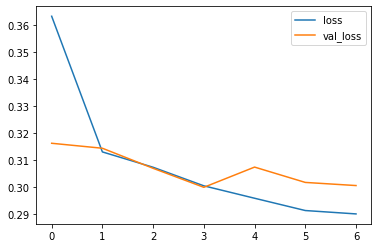

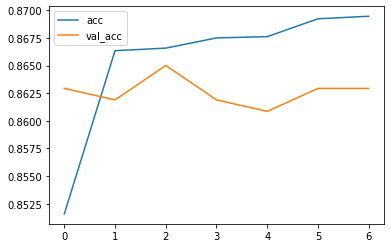

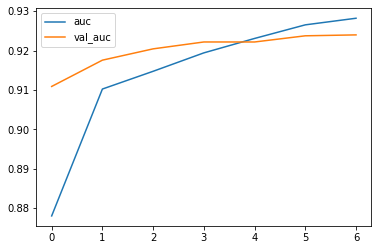

1204/1204 [==============================] - 1s 728us/sample - loss: 0.2845 - tp: 334.0000 - fp: 13.0000 - tn: 717.0000 - fn: 140.0000 - accuracy: 0.8729 - precision: 0.9625 - recall: 0.7046 - auc: 0.9264
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/100
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3632 - tp: 2182.0000 - fp: 74.0000 - tn: 5180.0000 - fn: 1228.0000 - accuracy: 0.8497 - precision: 0.9672 - recall: 0.6399 - auc: 0.8771 - val_loss: 0.3164 - val_tp: 245.0000 - val_fp: 2.0000 - val_tn: 585.0000 - val_fn: 131.0000 - val_accuracy: 0.8619 - val_precision: 0.9919 - val_recall: 0.6516 - val_auc: 0.9161
Epoch 2/100
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3137 - tp: 2276.0000 - fp: 10.0000 - tn: 5244.0000 - fn: 1134.0000 - accuracy: 0.8680 - precision: 0.9956 - recall: 0.6674 - auc: 0.9070 - val_loss: 0.3044 - val_tp: 247.0000 - val_fp: 2.0000 - val_tn: 585.0000 - val_fn: 129.0000 - val_accuracy: 0.86

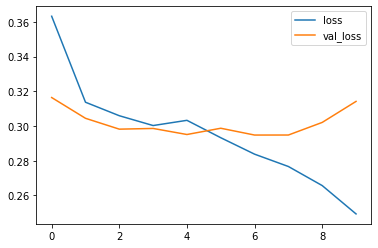

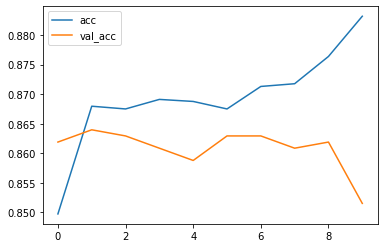

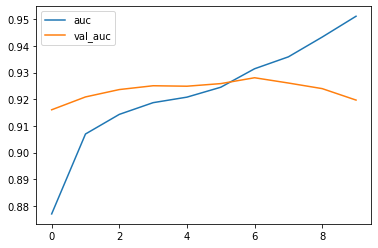

1204/1204 [==============================] - 1s 729us/sample - loss: 0.2782 - tp: 329.0000 - fp: 4.0000 - tn: 726.0000 - fn: 145.0000 - accuracy: 0.8762 - precision: 0.9880 - recall: 0.6941 - auc: 0.9329
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/100
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3670 - tp: 2236.0000 - fp: 69.0000 - tn: 5187.0000 - fn: 1172.0000 - accuracy: 0.8568 - precision: 0.9701 - recall: 0.6561 - auc: 0.8671 - val_loss: 0.3120 - val_tp: 254.0000 - val_fp: 6.0000 - val_tn: 579.0000 - val_fn: 124.0000 - val_accuracy: 0.8650 - val_precision: 0.9769 - val_recall: 0.6720 - val_auc: 0.9152
Epoch 2/100
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3119 - tp: 2281.0000 - fp: 10.0000 - tn: 5246.0000 - fn: 1127.0000 - accuracy: 0.8688 - precision: 0.9956 - recall: 0.6693 - auc: 0.9082 - val_loss: 0.2993 - val_tp: 251.0000 - val_fp: 0.0000e+00 - val_tn: 585.0000 - val_fn: 127.0000 - val_accuracy: 0

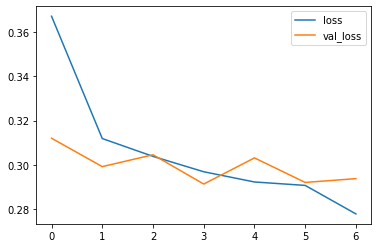

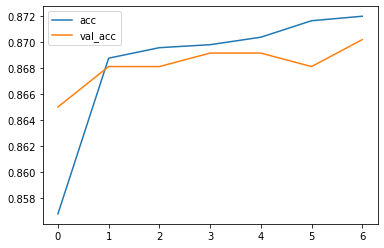

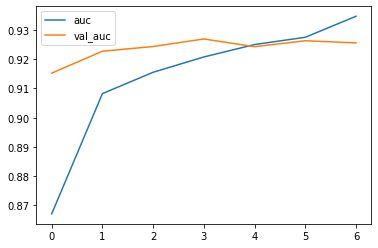

1204/1204 [==============================] - 1s 737us/sample - loss: 0.3169 - tp: 306.0000 - fp: 1.0000 - tn: 729.0000 - fn: 168.0000 - accuracy: 0.8596 - precision: 0.9967 - recall: 0.6456 - auc: 0.9091
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/100
8664/8664 [==============================] - 20s 2ms/sample - loss: 0.3589 - tp: 2193.0000 - fp: 55.0000 - tn: 5195.0000 - fn: 1221.0000 - accuracy: 0.8527 - precision: 0.9755 - recall: 0.6424 - auc: 0.8806 - val_loss: 0.3085 - val_tp: 246.0000 - val_fp: 1.0000 - val_tn: 589.0000 - val_fn: 127.0000 - val_accuracy: 0.8671 - val_precision: 0.9960 - val_recall: 0.6595 - val_auc: 0.9212
Epoch 2/100
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3064 - tp: 2298.0000 - fp: 12.0000 - tn: 5238.0000 - fn: 1116.0000 - accuracy: 0.8698 - precision: 0.9948 - recall: 0.6731 - auc: 0.9129 - val_loss: 0.3049 - val_tp: 243.0000 - val_fp: 0.0000e+00 - val_tn: 590.0000 - val_fn: 130.0000 - val_accuracy: 0

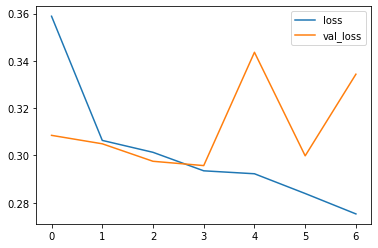

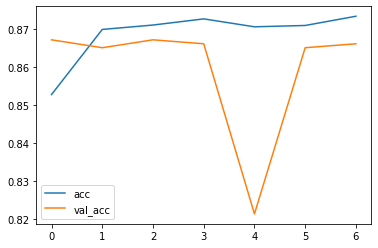

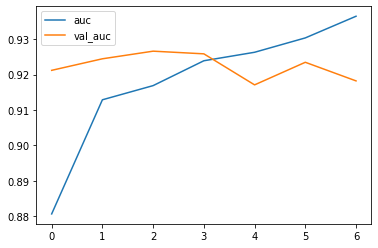

1204/1204 [==============================] - 1s 709us/sample - loss: 0.3293 - tp: 304.0000 - fp: 2.0000 - tn: 729.0000 - fn: 169.0000 - accuracy: 0.8580 - precision: 0.9935 - recall: 0.6427 - auc: 0.9068
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/100
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3587 - tp: 2194.0000 - fp: 69.0000 - tn: 5179.0000 - fn: 1223.0000 - accuracy: 0.8509 - precision: 0.9695 - recall: 0.6421 - auc: 0.8792 - val_loss: 0.3118 - val_tp: 236.0000 - val_fp: 0.0000e+00 - val_tn: 593.0000 - val_fn: 134.0000 - val_accuracy: 0.8609 - val_precision: 1.0000 - val_recall: 0.6378 - val_auc: 0.9147
Epoch 2/100
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3146 - tp: 2296.0000 - fp: 36.0000 - tn: 5212.0000 - fn: 1121.0000 - accuracy: 0.8665 - precision: 0.9846 - recall: 0.6719 - auc: 0.9088 - val_loss: 0.3071 - val_tp: 236.0000 - val_fp: 1.0000 - val_tn: 592.0000 - val_fn: 134.0000 - val_accuracy: 0

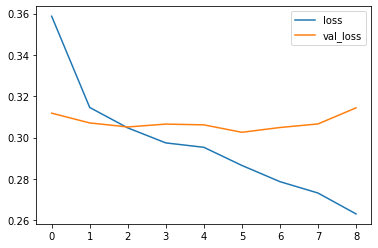

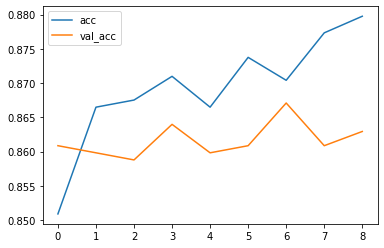

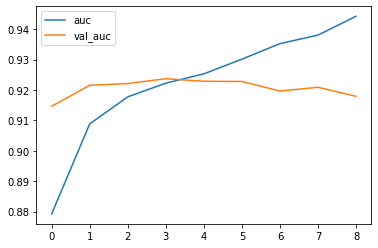

1203/1203 [==============================] - 1s 745us/sample - loss: 0.2975 - tp: 332.0000 - fp: 8.0000 - tn: 722.0000 - fn: 141.0000 - accuracy: 0.8761 - precision: 0.9765 - recall: 0.7019 - auc: 0.9147
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/100
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3628 - tp: 2189.0000 - fp: 74.0000 - tn: 5180.0000 - fn: 1222.0000 - accuracy: 0.8504 - precision: 0.9673 - recall: 0.6417 - auc: 0.8808 - val_loss: 0.3401 - val_tp: 246.0000 - val_fp: 7.0000 - val_tn: 580.0000 - val_fn: 130.0000 - val_accuracy: 0.8577 - val_precision: 0.9723 - val_recall: 0.6543 - val_auc: 0.9146
Epoch 2/100
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3108 - tp: 2278.0000 - fp: 8.0000 - tn: 5246.0000 - fn: 1133.0000 - accuracy: 0.8683 - precision: 0.9965 - recall: 0.6678 - auc: 0.9104 - val_loss: 0.3078 - val_tp: 245.0000 - val_fp: 0.0000e+00 - val_tn: 587.0000 - val_fn: 131.0000 - val_accuracy: 0.

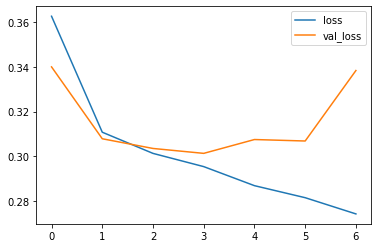

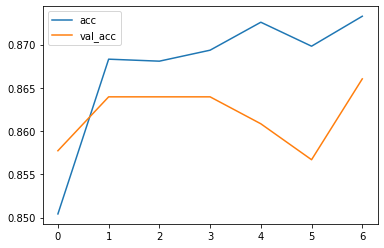

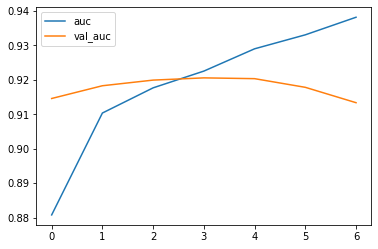

1203/1203 [==============================] - 1s 680us/sample - loss: 0.2949 - tp: 322.0000 - fp: 0.0000e+00 - tn: 730.0000 - fn: 151.0000 - accuracy: 0.8745 - precision: 1.0000 - recall: 0.6808 - auc: 0.9235
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/100
8665/8665 [==============================] - 20s 2ms/sample - loss: 0.3571 - tp: 2174.0000 - fp: 33.0000 - tn: 5218.0000 - fn: 1240.0000 - accuracy: 0.8531 - precision: 0.9850 - recall: 0.6368 - auc: 0.8818 - val_loss: 0.3040 - val_tp: 247.0000 - val_fp: 0.0000e+00 - val_tn: 590.0000 - val_fn: 126.0000 - val_accuracy: 0.8692 - val_precision: 1.0000 - val_recall: 0.6622 - val_auc: 0.9221
Epoch 2/100
8665/8665 [==============================] - 18s 2ms/sample - loss: 0.3096 - tp: 2300.0000 - fp: 13.0000 - tn: 5238.0000 - fn: 1114.0000 - accuracy: 0.8699 - precision: 0.9944 - recall: 0.6737 - auc: 0.9091 - val_loss: 0.2915 - val_tp: 248.0000 - val_fp: 1.0000 - val_tn: 589.0000 - val_fn: 125.0000 - val_accurac

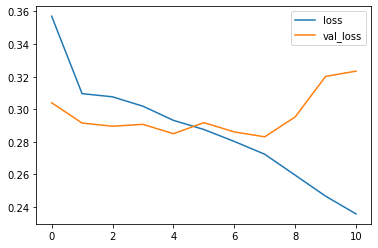

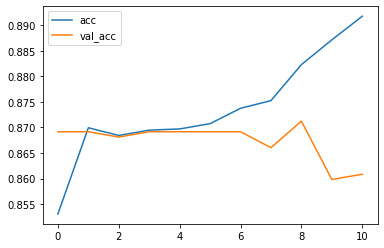

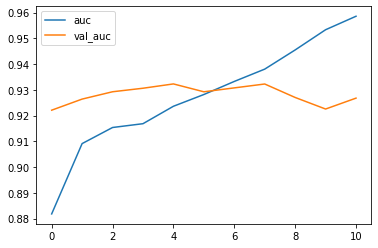

1203/1203 [==============================] - 1s 708us/sample - loss: 0.3178 - tp: 321.0000 - fp: 12.0000 - tn: 718.0000 - fn: 152.0000 - accuracy: 0.8637 - precision: 0.9640 - recall: 0.6786 - auc: 0.9108
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/100
8665/8665 [==============================] - 20s 2ms/sample - loss: 0.3552 - tp: 2156.0000 - fp: 48.0000 - tn: 5204.0000 - fn: 1257.0000 - accuracy: 0.8494 - precision: 0.9782 - recall: 0.6317 - auc: 0.8849 - val_loss: 0.3301 - val_tp: 255.0000 - val_fp: 18.0000 - val_tn: 571.0000 - val_fn: 119.0000 - val_accuracy: 0.8577 - val_precision: 0.9341 - val_recall: 0.6818 - val_auc: 0.9179
Epoch 2/100
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3516 - tp: 2278.0000 - fp: 109.0000 - tn: 5143.0000 - fn: 1135.0000 - accuracy: 0.8564 - precision: 0.9543 - recall: 0.6674 - auc: 0.8972 - val_loss: 0.3640 - val_tp: 267.0000 - val_fp: 53.0000 - val_tn: 536.0000 - val_fn: 107.0000 - val_accuracy: 0

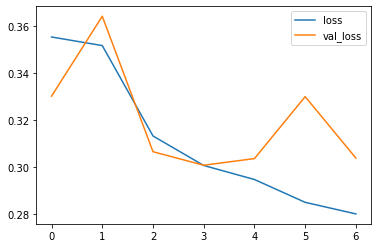

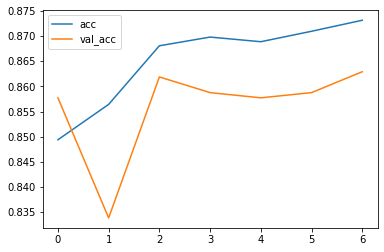

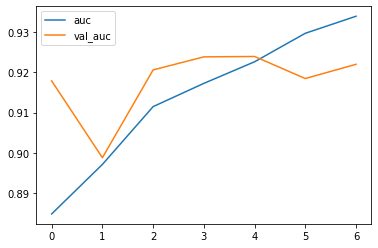

1203/1203 [==============================] - 1s 702us/sample - loss: 0.3075 - tp: 319.0000 - fp: 6.0000 - tn: 724.0000 - fn: 154.0000 - accuracy: 0.8670 - precision: 0.9815 - recall: 0.6744 - auc: 0.9155
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/100
8665/8665 [==============================] - 19s 2ms/sample - loss: 0.3553 - tp: 2174.0000 - fp: 50.0000 - tn: 5211.0000 - fn: 1230.0000 - accuracy: 0.8523 - precision: 0.9775 - recall: 0.6387 - auc: 0.8835 - val_loss: 0.3236 - val_tp: 244.0000 - val_fp: 1.0000 - val_tn: 579.0000 - val_fn: 139.0000 - val_accuracy: 0.8546 - val_precision: 0.9959 - val_recall: 0.6371 - val_auc: 0.9117
Epoch 2/100
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3108 - tp: 2302.0000 - fp: 43.0000 - tn: 5218.0000 - fn: 1102.0000 - accuracy: 0.8679 - precision: 0.9817 - recall: 0.6763 - auc: 0.9109 - val_loss: 0.3193 - val_tp: 263.0000 - val_fp: 19.0000 - val_tn: 561.0000 - val_fn: 120.0000 - val_accuracy: 0.85

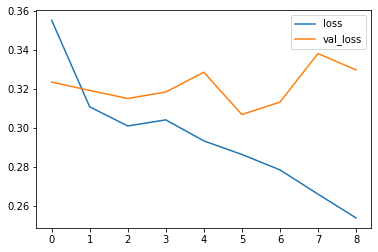

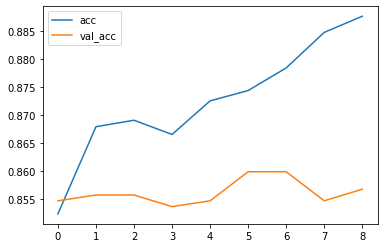

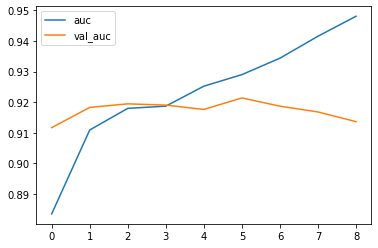

1203/1203 [==============================] - 1s 759us/sample - loss: 0.2980 - tp: 343.0000 - fp: 50.0000 - tn: 680.0000 - fn: 130.0000 - accuracy: 0.8504 - precision: 0.8728 - recall: 0.7252 - auc: 0.9233


In [0]:

# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 9

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, padding='valid', activation='relu', strides=1),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )


# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
    #callbacks=[es, mc]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  cvscores = cvscores.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 'auc': scores[8]}, ignore_index=True)

In [0]:
cvscores

,tp,fp,tn,fn,accuracy,precision,recall,auc
0,334.0,13.0,717.0,140.0,0.872924,0.962536,0.704641,0.926383
1,329.0,4.0,726.0,145.0,0.876246,0.987988,0.694093,0.932888
2,306.0,1.0,729.0,168.0,0.859635,0.996743,0.645570,0.909054
3,304.0,2.0,729.0,169.0,0.857973,0.993464,0.642706,0.906848
4,332.0,8.0,722.0,141.0,0.876143,0.976471,0.701903,0.914689
5,322.0,0.0,730.0,151.0,0.874480,1.000000,0.680761,0.923451
6,321.0,12.0,718.0,152.0,0.863674,0.963964,0.678647,0.910782
7,319.0,6.0,724.0,154.0,0.866999,0.981538,0.674419,0.915510
8,343.0,50.0,680.0,130.0,0.850374,0.872774,0.725159,0.923295


In [0]:
cvscores.mean(axis = 0)

tp           323.333333
fp            10.666667
tn           719.444444
fn           150.000000
accuracy       0.866494
precision      0.970609
recall         0.683100
auc            0.918100
dtype: float64


2
tp           1439.000000
fp             37.500000
tn           3248.000000
fn            691.000000
accuracy        0.865478
precision       0.975306
recall          0.675587
auc             0.914406
dtype: float64

3
tp            966.333333
fp             36.333333
tn           2154.000000
fn            453.666667
accuracy        0.864278
precision       0.965268
recall          0.680516
auc             0.916518
dtype: float64

4
tp            717.500000
fp             17.500000
tn           1625.250000
fn            347.500000
accuracy        0.865202
precision       0.976712
recall          0.673709
auc             0.914950
dtype: float64

5
tp            596.000000
fp             35.800000
tn           1278.400000
fn            256.000000
accuracy        0.865294
precision       0.943648
recall          0.699531
auc             0.915473
dtype: float64

6
tp            500.333333
fp             39.333333
tn           1055.833333
fn            209.666667
accuracy        0.862063
precision       0.934375
recall          0.704695
auc             0.917706
dtype: float64

7
tp           418.000000
fp            14.714286
tn           924.000000
fn           190.571429
accuracy       0.867325
precision      0.966591
recall         0.686849
auc            0.918389
dtype: float64

8
tp           365.625000
fp            14.125000
tn           807.250000
fn           166.875000
accuracy       0.866309
precision      0.963745
recall         0.686625
auc            0.918316
dtype: float64

9

tp           323.111111
fp             7.777778
tn           722.333333
fn           150.222222
accuracy       0.868712
precision      0.977175
recall         0.682621
auc            0.918562
dtype: float64

10

tp           296.000000
fp            15.800000
tn           641.300000
fn           130.000000
accuracy       0.865387
precision      0.954205
recall         0.694836
auc            0.917503
dtype: float64

##### Bi-LSTM + CNN

9
tp           323.333333
fp            10.666667
tn           719.444444
fn           150.000000
accuracy       0.866494
precision      0.970609
recall         0.683100
auc            0.918100
dtype: float64



##### Bi-LSTM + Attention Layer

In [0]:
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

Building Bi-LSTM model...
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/50
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3672 - tp: 2104.0000 - fp: 28.0000 - tn: 5230.0000 - fn: 1302.0000 - accuracy: 0.8465 - precision: 0.9869 - recall: 0.6177 - auc: 0.8797 - val_loss: 0.3194 - val_tp: 249.0000 - val_fp: 1.0000 - val_tn: 582.0000 - val_fn: 131.0000 - val_accuracy: 0.8629 - val_precision: 0.9960 - val_recall: 0.6553 - val_auc: 0.9162
Epoch 2/50
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3073 - tp: 2293.0000 - fp: 28.0000 - tn: 5230.0000 - fn: 1113.0000 - accuracy: 0.8683 - precision: 0.9879 - recall: 0.6732 - auc: 0.9135 - val_loss: 0.3072 - val_tp: 251.0000 - val_fp: 3.0000 - val_tn: 580.0000 - val_fn: 129.0000 - val_accuracy: 0.8629 - val_precision: 0.9882 - val_recall: 0.6605 - val_auc: 0.9198
Epoch 3/50
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.2994 - tp: 2337.0000 - fp: 55.0000

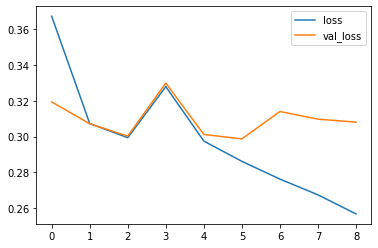

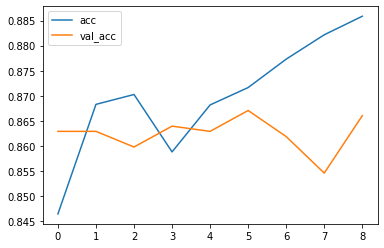

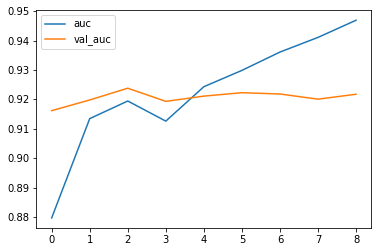

1204/1204 [==============================] - 1s 707us/sample - loss: 0.2835 - tp: 342.0000 - fp: 11.0000 - tn: 719.0000 - fn: 132.0000 - accuracy: 0.8812 - precision: 0.9688 - recall: 0.7215 - auc: 0.9277
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/50
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3617 - tp: 2129.0000 - fp: 33.0000 - tn: 5221.0000 - fn: 1281.0000 - accuracy: 0.8483 - precision: 0.9847 - recall: 0.6243 - auc: 0.8836 - val_loss: 0.3093 - val_tp: 247.0000 - val_fp: 6.0000 - val_tn: 581.0000 - val_fn: 129.0000 - val_accuracy: 0.8598 - val_precision: 0.9763 - val_recall: 0.6569 - val_auc: 0.9174
Epoch 2/50
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3090 - tp: 2295.0000 - fp: 42.0000 - tn: 5212.0000 - fn: 1115.0000 - accuracy: 0.8665 - precision: 0.9820 - recall: 0.6730 - auc: 0.9123 - val_loss: 0.3075 - val_tp: 247.0000 - val_fp: 6.0000 - val_tn: 581.0000 - val_fn: 129.0000 - val_accuracy: 0.8598

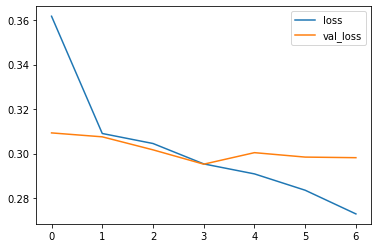

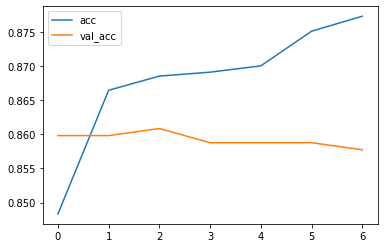

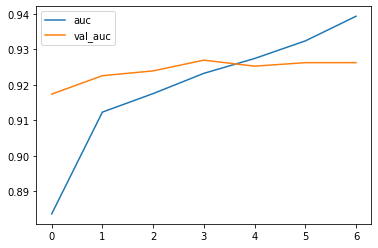

1204/1204 [==============================] - 1s 716us/sample - loss: 0.2839 - tp: 362.0000 - fp: 47.0000 - tn: 683.0000 - fn: 112.0000 - accuracy: 0.8679 - precision: 0.8851 - recall: 0.7637 - auc: 0.9314
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/50
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3644 - tp: 2123.0000 - fp: 46.0000 - tn: 5210.0000 - fn: 1285.0000 - accuracy: 0.8464 - precision: 0.9788 - recall: 0.6229 - auc: 0.8816 - val_loss: 0.3113 - val_tp: 254.0000 - val_fp: 6.0000 - val_tn: 579.0000 - val_fn: 124.0000 - val_accuracy: 0.8650 - val_precision: 0.9769 - val_recall: 0.6720 - val_auc: 0.9228
Epoch 2/50
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3048 - tp: 2325.0000 - fp: 41.0000 - tn: 5215.0000 - fn: 1083.0000 - accuracy: 0.8703 - precision: 0.9827 - recall: 0.6822 - auc: 0.9145 - val_loss: 0.2909 - val_tp: 258.0000 - val_fp: 8.0000 - val_tn: 577.0000 - val_fn: 120.0000 - val_accuracy: 0.8671

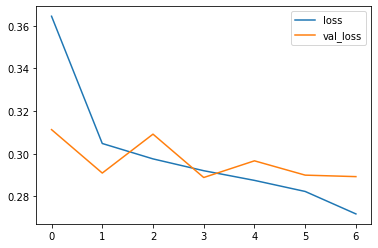

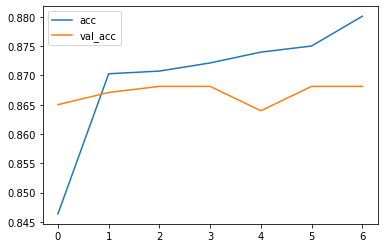

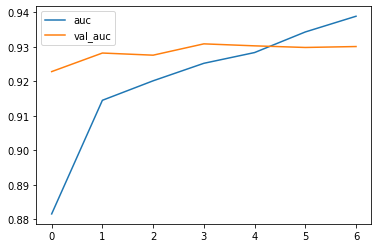

1204/1204 [==============================] - 1s 737us/sample - loss: 0.3120 - tp: 317.0000 - fp: 11.0000 - tn: 719.0000 - fn: 157.0000 - accuracy: 0.8605 - precision: 0.9665 - recall: 0.6688 - auc: 0.9142
Training model...
Train on 8664 samples, validate on 963 samples
Epoch 1/50
8664/8664 [==============================] - 17s 2ms/sample - loss: 0.3666 - tp: 2114.0000 - fp: 35.0000 - tn: 5215.0000 - fn: 1300.0000 - accuracy: 0.8459 - precision: 0.9837 - recall: 0.6192 - auc: 0.8774 - val_loss: 0.2974 - val_tp: 248.0000 - val_fp: 5.0000 - val_tn: 585.0000 - val_fn: 125.0000 - val_accuracy: 0.8650 - val_precision: 0.9802 - val_recall: 0.6649 - val_auc: 0.9242
Epoch 2/50
8664/8664 [==============================] - 12s 1ms/sample - loss: 0.3047 - tp: 2325.0000 - fp: 43.0000 - tn: 5207.0000 - fn: 1089.0000 - accuracy: 0.8693 - precision: 0.9818 - recall: 0.6810 - auc: 0.9140 - val_loss: 0.2970 - val_tp: 249.0000 - val_fp: 6.0000 - val_tn: 584.0000 - val_fn: 124.0000 - val_accuracy: 0.8650

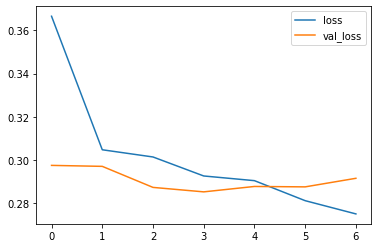

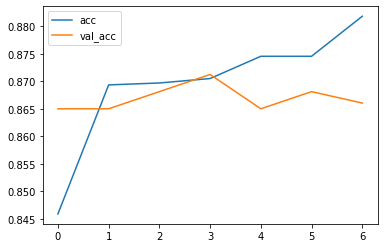

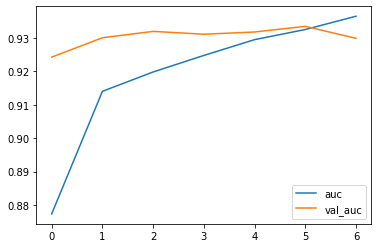

1204/1204 [==============================] - 1s 713us/sample - loss: 0.3233 - tp: 320.0000 - fp: 15.0000 - tn: 716.0000 - fn: 153.0000 - accuracy: 0.8605 - precision: 0.9552 - recall: 0.6765 - auc: 0.9074
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/50
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3744 - tp: 2129.0000 - fp: 64.0000 - tn: 5184.0000 - fn: 1288.0000 - accuracy: 0.8440 - precision: 0.9708 - recall: 0.6231 - auc: 0.8761 - val_loss: 0.3213 - val_tp: 236.0000 - val_fp: 1.0000 - val_tn: 592.0000 - val_fn: 134.0000 - val_accuracy: 0.8598 - val_precision: 0.9958 - val_recall: 0.6378 - val_auc: 0.9110
Epoch 2/50
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3080 - tp: 2309.0000 - fp: 32.0000 - tn: 5216.0000 - fn: 1108.0000 - accuracy: 0.8684 - precision: 0.9863 - recall: 0.6757 - auc: 0.9136 - val_loss: 0.3093 - val_tp: 235.0000 - val_fp: 1.0000 - val_tn: 592.0000 - val_fn: 135.0000 - val_accuracy: 0.8588

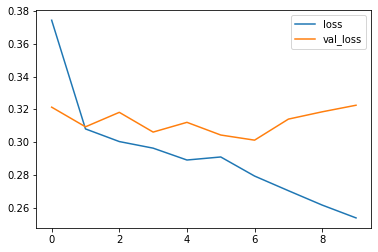

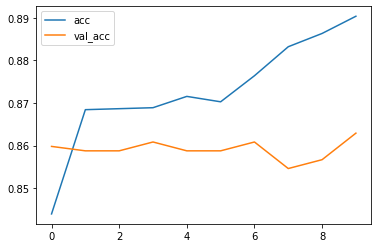

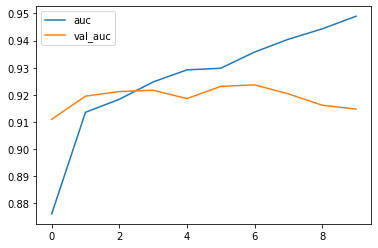

1203/1203 [==============================] - 1s 699us/sample - loss: 0.2980 - tp: 343.0000 - fp: 22.0000 - tn: 708.0000 - fn: 130.0000 - accuracy: 0.8736 - precision: 0.9397 - recall: 0.7252 - auc: 0.9175
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/50
8665/8665 [==============================] - 19s 2ms/sample - loss: 0.3641 - tp: 2159.0000 - fp: 55.0000 - tn: 5199.0000 - fn: 1252.0000 - accuracy: 0.8492 - precision: 0.9752 - recall: 0.6330 - auc: 0.8736 - val_loss: 0.3119 - val_tp: 246.0000 - val_fp: 5.0000 - val_tn: 582.0000 - val_fn: 130.0000 - val_accuracy: 0.8598 - val_precision: 0.9801 - val_recall: 0.6543 - val_auc: 0.9172
Epoch 2/50
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3087 - tp: 2298.0000 - fp: 24.0000 - tn: 5230.0000 - fn: 1113.0000 - accuracy: 0.8688 - precision: 0.9897 - recall: 0.6737 - auc: 0.9115 - val_loss: 0.3040 - val_tp: 245.0000 - val_fp: 0.0000e+00 - val_tn: 587.0000 - val_fn: 131.0000 - val_accuracy: 0.

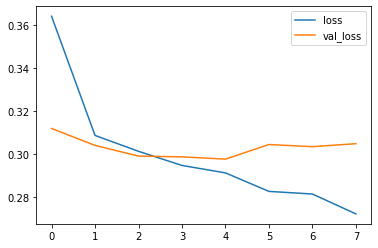

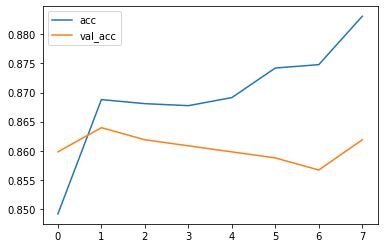

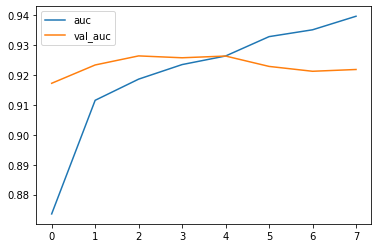

1203/1203 [==============================] - 1s 723us/sample - loss: 0.2869 - tp: 331.0000 - fp: 3.0000 - tn: 727.0000 - fn: 142.0000 - accuracy: 0.8795 - precision: 0.9910 - recall: 0.6998 - auc: 0.9266
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/50
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3703 - tp: 2101.0000 - fp: 22.0000 - tn: 5229.0000 - fn: 1313.0000 - accuracy: 0.8459 - precision: 0.9896 - recall: 0.6154 - auc: 0.8755 - val_loss: 0.3073 - val_tp: 244.0000 - val_fp: 3.0000 - val_tn: 587.0000 - val_fn: 129.0000 - val_accuracy: 0.8629 - val_precision: 0.9879 - val_recall: 0.6542 - val_auc: 0.9186
Epoch 2/50
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3109 - tp: 2302.0000 - fp: 31.0000 - tn: 5220.0000 - fn: 1112.0000 - accuracy: 0.8681 - precision: 0.9867 - recall: 0.6743 - auc: 0.9100 - val_loss: 0.2945 - val_tp: 247.0000 - val_fp: 2.0000 - val_tn: 588.0000 - val_fn: 126.0000 - val_accuracy: 0.8671 

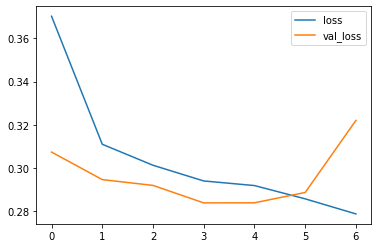

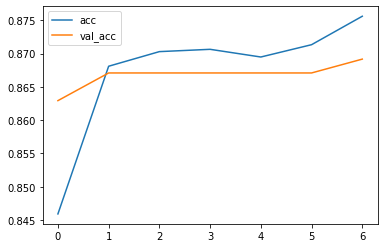

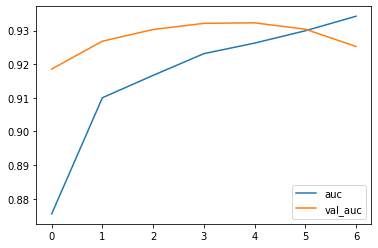

1203/1203 [==============================] - 1s 718us/sample - loss: 0.3240 - tp: 318.0000 - fp: 15.0000 - tn: 715.0000 - fn: 155.0000 - accuracy: 0.8587 - precision: 0.9550 - recall: 0.6723 - auc: 0.9072
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/50
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3626 - tp: 2142.0000 - fp: 33.0000 - tn: 5219.0000 - fn: 1271.0000 - accuracy: 0.8495 - precision: 0.9848 - recall: 0.6276 - auc: 0.8792 - val_loss: 0.3093 - val_tp: 247.0000 - val_fp: 2.0000 - val_tn: 587.0000 - val_fn: 127.0000 - val_accuracy: 0.8660 - val_precision: 0.9920 - val_recall: 0.6604 - val_auc: 0.9161
Epoch 2/50
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3055 - tp: 2316.0000 - fp: 34.0000 - tn: 5218.0000 - fn: 1097.0000 - accuracy: 0.8695 - precision: 0.9855 - recall: 0.6786 - auc: 0.9136 - val_loss: 0.3067 - val_tp: 247.0000 - val_fp: 3.0000 - val_tn: 586.0000 - val_fn: 127.0000 - val_accuracy: 0.8650

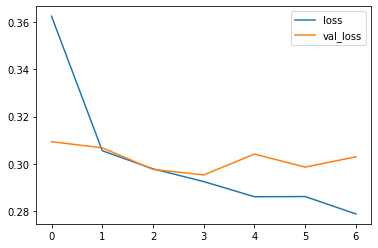

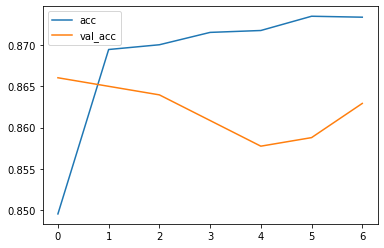

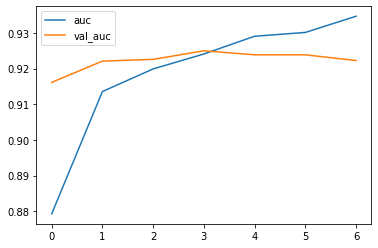

1203/1203 [==============================] - 1s 720us/sample - loss: 0.2993 - tp: 319.0000 - fp: 4.0000 - tn: 726.0000 - fn: 154.0000 - accuracy: 0.8687 - precision: 0.9876 - recall: 0.6744 - auc: 0.9215
Training model...
Train on 8665 samples, validate on 963 samples
Epoch 1/50
8665/8665 [==============================] - 17s 2ms/sample - loss: 0.3664 - tp: 2143.0000 - fp: 80.0000 - tn: 5181.0000 - fn: 1261.0000 - accuracy: 0.8452 - precision: 0.9640 - recall: 0.6296 - auc: 0.8781 - val_loss: 0.3249 - val_tp: 244.0000 - val_fp: 0.0000e+00 - val_tn: 580.0000 - val_fn: 139.0000 - val_accuracy: 0.8557 - val_precision: 1.0000 - val_recall: 0.6371 - val_auc: 0.9126
Epoch 2/50
8665/8665 [==============================] - 12s 1ms/sample - loss: 0.3123 - tp: 2277.0000 - fp: 27.0000 - tn: 5234.0000 - fn: 1127.0000 - accuracy: 0.8668 - precision: 0.9883 - recall: 0.6689 - auc: 0.9102 - val_loss: 0.3095 - val_tp: 247.0000 - val_fp: 3.0000 - val_tn: 577.0000 - val_fn: 136.0000 - val_accuracy: 0.8

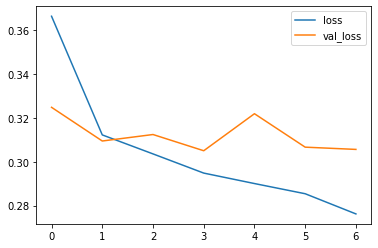

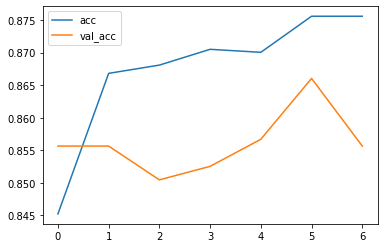

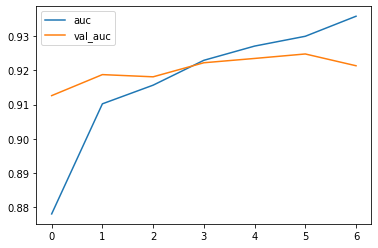

1203/1203 [==============================] - 1s 694us/sample - loss: 0.2935 - tp: 328.0000 - fp: 14.0000 - tn: 716.0000 - fn: 145.0000 - accuracy: 0.8678 - precision: 0.9591 - recall: 0.6934 - auc: 0.9248


In [0]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 50   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 9

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS , shuffle=True, random_state = 7)
cvscores_att = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

for train, test in kfold.split(texts, labels):

  input_ = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
# x = GlobalMaxPool1D()(x)
  att_out = attention()(x)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(att_out)

  model = tf.keras.models.Model(input_, output)
  #model = tf.keras.Sequential([
    #Embedding

   #    tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       #tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, padding='valid', activation='relu', strides=1),
    #   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

       #tf.keras.layers.GlobalAveragePooling1D(),
     #  tf.keras.layers.Dense(32, activation='relu'),
      # tf.keras.layers.Dense(1, activation='sigmoid')
  #])

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )


# Training model:
# parameters: batch_size, epoches
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# load a saved model

  from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(relevance_train.values), relevance_train.values)
#class_weight_dict = dict(enumerate(class_weights))

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
    #callbacks=[es, mc],
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#saved_model = tf.keras.models.load_model('best_model.h5')
#saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

#saved_model.evaluate(x = test_c, y = relevance_test.values)
  scores = model.evaluate(x = texts[test], y = labels[test])
  cvscores_att = cvscores_att.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 'auc': scores[8]}, ignore_index=True)

In [0]:
cvscores_att

,tp,fp,tn,fn,accuracy,precision,recall,auc
0,342.0,11.0,719.0,132.0,0.881229,0.968839,0.721519,0.927722
1,362.0,47.0,683.0,112.0,0.867940,0.885086,0.763713,0.931365
2,317.0,11.0,719.0,157.0,0.860465,0.966463,0.668776,0.914180
3,320.0,15.0,716.0,153.0,0.860465,0.955224,0.676533,0.907382
4,343.0,22.0,708.0,130.0,0.873649,0.939726,0.725159,0.917546
5,331.0,3.0,727.0,142.0,0.879468,0.991018,0.699789,0.926581
6,318.0,15.0,715.0,155.0,0.858687,0.954955,0.672304,0.907232
7,319.0,4.0,726.0,154.0,0.868662,0.987616,0.674419,0.921538
8,328.0,14.0,716.0,145.0,0.867830,0.959064,0.693446,0.924810


In [0]:
cvscores_att.mean(axis = 0)

tp           331.111111
fp            15.777778
tn           714.333333
fn           142.222222
accuracy       0.868711
precision      0.956443
recall         0.699518
auc            0.919817
dtype: float64

#### Learning rate 0.0001

##### Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/1000
8772/8772 [==============================] - 17s 2ms/sample - loss: 0.5460 - tp: 1325.0000 - fp: 19.0000 - tn: 5302.0000 - fn: 2126.0000 - accuracy: 0.7555 - precision: 0.9859 - recall: 0.3839 - auc: 0.7903 - val_loss: 0.4199 - val_tp: 252.0000 - val_fp: 8.0000 - val_tn: 584.0000 - val_fn: 131.0000 - val_accuracy: 0.8574 - val_precision: 0.9692 - val_recall: 0.6580 - val_auc: 0.8393
Epoch 2/1000
8772/8772 [==============================] - 12s 1ms/sample - loss: 0.3703 - tp: 2286.0000 - fp: 35.0000 - tn: 5286.0000 - fn: 1165.0000 - accuracy: 0.8632 - precision: 0.9849 - recall: 0.6624 - auc: 0.8393 - val_loss: 0.3554 - val_tp: 251.0000 - val_fp: 2.0000 - val_tn: 590.0000 - val_fn: 132.0000 - val_accuracy: 0.8626 - val_precision: 0.9921 - val_recall: 0.6554 - val_auc: 0.8552
Epoch 3/1000
8772/8772 [==============================] - 12s 1ms/sample - loss: 0.3492 - tp: 2287.0000 - fp: 1

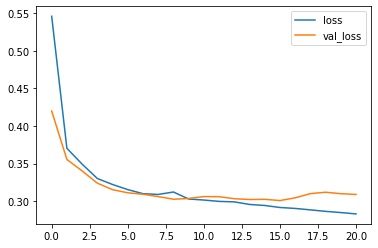

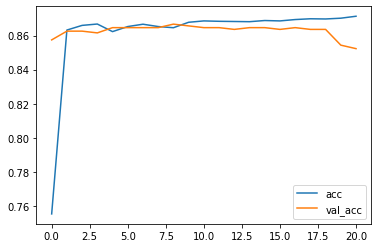

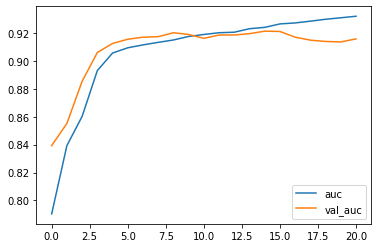

1084/1084 [==============================] - 1s 737us/sample - loss: 0.2857 - tp: 298.0000 - fp: 3.0000 - tn: 655.0000 - fn: 128.0000 - accuracy: 0.8792 - precision: 0.9900 - recall: 0.6995 - auc: 0.9237
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 20s 2ms/sample - loss: 0.5519 - tp: 1189.0000 - fp: 3.0000 - tn: 5319.0000 - fn: 2262.0000 - accuracy: 0.7418 - precision: 0.9975 - recall: 0.3445 - auc: 0.7973 - val_loss: 0.4211 - val_tp: 252.0000 - val_fp: 6.0000 - val_tn: 586.0000 - val_fn: 131.0000 - val_accuracy: 0.8595 - val_precision: 0.9767 - val_recall: 0.6580 - val_auc: 0.8483
Epoch 2/1000
4128/8773 [=============>................] - ETA: 6s - loss: 0.3842 - tp: 1101.0000 - fp: 14.0000 - tn: 2480.0000 - fn: 533.0000 - accuracy: 0.8675 - precision: 0.9874 - recall: 0.6738 - auc: 0.8535

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,tp,fp,tn,fn,accuracy,precision,recall,auc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyboardInterrupt: ignored

In [0]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.0001

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)
cvscores_1 = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
    #Embedding

       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )


# Training model:
# parameters: batch_size, epoches
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# load a saved model

  from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(relevance_train.values), relevance_train.values)
#class_weight_dict = dict(enumerate(class_weights))

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
    #callbacks=[es, mc],
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#saved_model = tf.keras.models.load_model('best_model.h5')
#saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

#saved_model.evaluate(x = test_c, y = relevance_test.values)
  scores = model.evaluate(x = texts[test], y = labels[test])
  cvscores_1 = cvscores_1.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 'auc': scores[8]}, ignore_index=True)

In [0]:
cvscores_1

,tp,fp,tn,fn,accuracy,precision,recall,auc
0,297.0,3.0,655.0,129.0,0.878229,0.990000,0.697183,0.917029
1,293.0,5.0,652.0,133.0,0.872576,0.983221,0.687793,0.919307
2,289.0,8.0,649.0,137.0,0.866113,0.973064,0.678404,0.910110
3,291.0,22.0,635.0,135.0,0.855032,0.929712,0.683099,0.898841
4,273.0,0.0,657.0,153.0,0.858726,1.000000,0.640845,0.903031
5,293.0,1.0,656.0,133.0,0.876270,0.996599,0.687793,0.913335


In [0]:
cvscores_1.mean()

tp           289.333333
fp             6.500000
tn           650.666667
fn           136.666667
accuracy       0.867824
precision      0.978766
recall         0.679186
auc            0.910275
dtype: float64

# Sentiment Analysis

## Data Augmentation

In [0]:
data_s = data[['texts','positivity']][data['relevance']==1]

In [0]:
# use the function in Oversampling
def oversample(wordlist, pos): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)
        synonym = random.choice(list(synonyms))
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]])
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','positivity'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['positivity']  = pos
  return augmented_sentences

In [24]:
sentence = data_s['texts']
pos = data_s['positivity']
word_list = sentence.str.split()

random.seed(55)
data_s = data_s.append(oversample(word_list, pos))
data_s.reset_index()

,index,texts,positivity
0,0,yield cd fall late week new york yield cert...,3.0
1,4,currency trading dollar remain tight range a...,3.0
2,5,stock fall bofa alcoa slide stock decline ...,3.0
3,9,u s dollar fall currency decline soften bo...,4.0
4,12,defend deflation author james b stewartthe...,4.0
...,...,...,...
2835,7973,housing start grow raise inflation fear econom...,7.0
2836,7974,profit evasive stock mart rally greer philip c...,3.0
2837,7984,salomon sound wary note economy clinton admini...,8.0
2838,7987,great terror massive new history hitler tyrann...,5.0


## Baselines - Naive Bayes and SVM

In [0]:
texts = data_s['texts'].values
labels = data_s['positivity'].values

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state = 7)
acc_svm = pd.DataFrame(columns = ['accuracy'])

for train, test in kfold.split(texts, labels):
# Train both models on the moviereviews.tsv training set:
  text_clf_lsvc.fit(texts[train], labels[train])
  predictions_svm = text_clf_lsvc.predict(texts[test])
  acc_svm = acc_svm.append({'accuracy': metrics.accuracy_score(labels[test], predictions_svm)},  ignore_index=True)
  

In [32]:
acc_svm

,accuracy
0,0.635211
1,0.655634


In [33]:
acc_svm.mean()

accuracy    0.645423
dtype: float64

## Bi-LSTM

In [0]:
# some configuration

MAX_SEQUENCE_LENGTH = 427   # max sentence length 427 words
EMBEDDING_DIM = 300    # word vector dimension

### Word Embedding Weights

In [26]:
# T: number of obersavatons in dataset

# load in pre-trained word vectors
# size: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data_s['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# get word -> integer mapping
# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Loading word vectors...
Found 10932 unique tokens.


In [27]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
542, or 4.96% of total 10932 unique words are not covered


### Padding

In [28]:
sequences = tokenizer.texts_to_sequences(data_s['texts'].values)  # list, size T x number of words in each line (each line fluctuates)
texts = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', texts.shape)

Shape of test data tensor: (2840, 427)


### Model

#### Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 1278 samples, validate on 142 samples
Epoch 1/1000
1278/1278 [==============================] - 41s 32ms/sample - loss: 0.3486 - accuracy: 0.8745 - auc: 0.6882 - val_loss: 0.3426 - val_accuracy: 0.8750 - val_auc: 0.6890
Epoch 2/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.3367 - accuracy: 0.8750 - auc: 0.7212 - val_loss: 0.3426 - val_accuracy: 0.8750 - val_auc: 0.7015
Epoch 3/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.3277 - accuracy: 0.8750 - auc: 0.7532 - val_loss: 0.3356 - val_accuracy: 0.8741 - val_auc: 0.7267
Epoch 4/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.3113 - accuracy: 0.8757 - auc: 0.7982 - val_loss: 0.3316 - val_accuracy: 0.8732 - val_auc: 0.7399
Epoch 5/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.2957 - accuracy: 0.8807 - auc: 0.8254 - val_loss: 0.3279 - val_accuracy: 0.8759 - val_auc: 0.7512

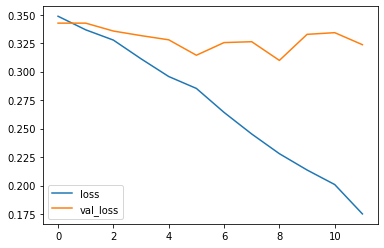

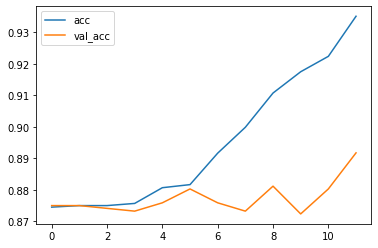

1420/1420 [==============================] - 2s 1ms/sample - loss: 0.3031 - accuracy: 0.8828 - auc: 0.8143
Training model...
Train on 1278 samples, validate on 142 samples
Epoch 1/1000
1278/1278 [==============================] - 40s 31ms/sample - loss: 0.3434 - accuracy: 0.8736 - auc: 0.7054 - val_loss: 0.3653 - val_accuracy: 0.8750 - val_auc: 0.6725
Epoch 2/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.3317 - accuracy: 0.8750 - auc: 0.7323 - val_loss: 0.3551 - val_accuracy: 0.8750 - val_auc: 0.6756
Epoch 3/1000
1278/1278 [==============================] - 37s 29ms/sample - loss: 0.3221 - accuracy: 0.8750 - auc: 0.7672 - val_loss: 0.3584 - val_accuracy: 0.8768 - val_auc: 0.6719
Epoch 4/1000
1278/1278 [==============================] - 36s 28ms/sample - loss: 0.3058 - accuracy: 0.8753 - auc: 0.8068 - val_loss: 0.3575 - val_accuracy: 0.8724 - val_auc: 0.6984
Epoch 5/1000
1278/1278 [==============================] - 36s 28ms/sample - loss: 0.2908 - accuracy:

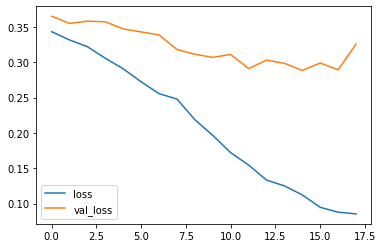

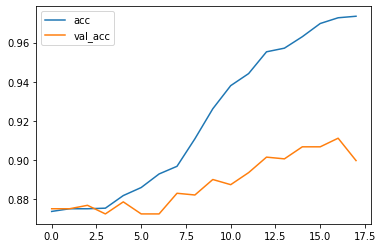

1420/1420 [==============================] - 2s 1ms/sample - loss: 0.3117 - accuracy: 0.8971 - auc: 0.8280


In [92]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 1   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 2

kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_s = pd.DataFrame(columns = ['accuracy'])
labels = data_s['positivity'].values

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
]


print('Building Bi-LSTM model...')
for train, test in kfold.split(texts, labels):

  labels_train = pd.get_dummies(labels[train])
  labels_test = pd.get_dummies(labels[test])
  m = sum(labels_train.columns)-sum(labels_test.columns)
  listofzeros = [0] * len(labels_test)
  if m > 0:
    labels_test[m] = listofzeros
  elif m < 0:
    labels_train[-m] = listofzeros

  model = tf.keras.Sequential([
      #Embedding

       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(8, activation='sigmoid')
  ])

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )

  # Training model:
  # parameters: batch_size, epoches
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
  #mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # fit model
  # load a saved model


  print('Training model...')
  r = model.fit(
  texts[train],
    labels_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
    #callbacks=[es, mc]
    ##class_weight = class_weight_dict
    #use_multiprocessing=True
  )

  #saved_model = tf.keras.models.load_model('best_model.h5')
  #saved_model.summary()
  model.summary()

  # plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

  # accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

  scores = model.evaluate(x = texts[test], y = labels_test)
  cvscores_s = cvscores_s.append({'accuracy': scores[1]}, ignore_index=True)

In [93]:
cvscores_s

,accuracy
0,0.882834
1,0.897095


In [94]:
cvscores_s.mean()

accuracy    0.889965
dtype: float64

#### Bi-LSTM + Attention

Building Bi-LSTM model...
Training model...
Train on 1136 samples, validate on 284 samples
Epoch 1/1000
1136/1136 [==============================] - 36s 32ms/sample - loss: 0.3498 - accuracy: 0.8722 - auc: 0.6849 - val_loss: 0.3441 - val_accuracy: 0.8750 - val_auc: 0.7096
Epoch 2/1000
1136/1136 [==============================] - 33s 29ms/sample - loss: 0.3361 - accuracy: 0.8750 - auc: 0.7243 - val_loss: 0.3467 - val_accuracy: 0.8750 - val_auc: 0.6880
Epoch 3/1000
1136/1136 [==============================] - 33s 29ms/sample - loss: 0.3236 - accuracy: 0.8749 - auc: 0.7648 - val_loss: 0.3265 - val_accuracy: 0.8763 - val_auc: 0.7580
Epoch 4/1000
1136/1136 [==============================] - 34s 30ms/sample - loss: 0.2998 - accuracy: 0.8798 - auc: 0.8177 - val_loss: 0.3134 - val_accuracy: 0.8759 - val_auc: 0.7869
Epoch 5/1000
1136/1136 [==============================] - 34s 30ms/sample - loss: 0.2737 - accuracy: 0.8886 - auc: 0.8565 - val_loss: 0.3065 - val_accuracy: 0.8820 - val_auc: 0.7994

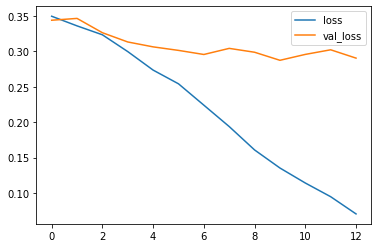

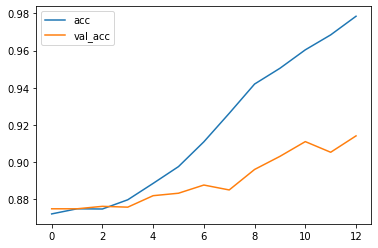

1420/1420 [==============================] - 2s 1ms/sample - loss: 0.3227 - accuracy: 0.8909 - auc: 0.8203
Training model...
Train on 1136 samples, validate on 284 samples
Epoch 1/1000
1136/1136 [==============================] - 37s 33ms/sample - loss: 0.3403 - accuracy: 0.8731 - auc: 0.7182 - val_loss: 0.3741 - val_accuracy: 0.8750 - val_auc: 0.6566
Epoch 2/1000
1136/1136 [==============================] - 34s 30ms/sample - loss: 0.3310 - accuracy: 0.8750 - auc: 0.7375 - val_loss: 0.3521 - val_accuracy: 0.8750 - val_auc: 0.6789
Epoch 3/1000
1136/1136 [==============================] - 34s 30ms/sample - loss: 0.3186 - accuracy: 0.8756 - auc: 0.7750 - val_loss: 0.3388 - val_accuracy: 0.8710 - val_auc: 0.7261
Epoch 4/1000
1136/1136 [==============================] - 34s 30ms/sample - loss: 0.2989 - accuracy: 0.8795 - auc: 0.8176 - val_loss: 0.3444 - val_accuracy: 0.8653 - val_auc: 0.7395
Epoch 5/1000
1136/1136 [==============================] - 35s 30ms/sample - loss: 0.2752 - accuracy:

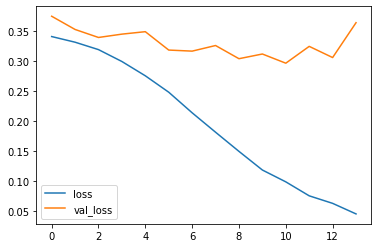

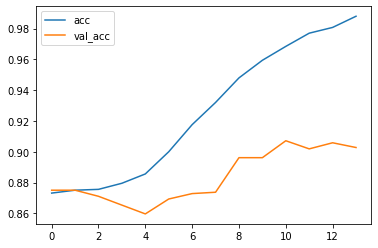

1420/1420 [==============================] - 2s 2ms/sample - loss: 0.3391 - accuracy: 0.8945 - auc: 0.8117


In [30]:
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.2   
BATCH_SIZE = 1   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 2

kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_s = pd.DataFrame(columns = ['accuracy'])
labels = data_s['positivity'].values

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
]

embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

print('Building Bi-LSTM model...')
for train, test in kfold.split(texts, labels):

  labels_train = pd.get_dummies(labels[train])
  labels_test = pd.get_dummies(labels[test])
  m = sum(labels_train.columns)-sum(labels_test.columns)
  listofzeros = [0] * len(labels_test)
  if m > 0:
    labels_test[m] = listofzeros
  elif m < 0:
    labels_train[-m] = listofzeros

  input_ = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
  att_out = attention()(x)
  output = tf.keras.layers.Dense(8, activation='sigmoid')(att_out)

  model = tf.keras.models.Model(input_, output)


  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )

  # Training model:
  # parameters: batch_size, epoches
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
  #mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # fit model
  # load a saved model


  print('Training model...')
  r = model.fit(
  texts[train],
    labels_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
    #callbacks=[es, mc]
    ##class_weight = class_weight_dict
    #use_multiprocessing=True
  )

  #saved_model = tf.keras.models.load_model('best_model.h5')
  #saved_model.summary()
  model.summary()

  # plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

  # accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

  scores = model.evaluate(x = texts[test], y = labels_test)
  cvscores_s = cvscores_s.append({'accuracy': scores[1]}, ignore_index=True)

In [31]:
cvscores_s

,accuracy
0,0.890933
1,0.894542


In [32]:
cvscores_s.mean()

accuracy    0.892738
dtype: float64